In [1]:
"""
05_model_inference.ipynb
Production inference with clinical explainability for cervical cancer screening
"""

# ============================================================
# Setup and Directory Management
# ============================================================
import os
import sys
from pathlib import Path

# Check current directory
print(f"Current directory: {os.getcwd()}")

# If we're in the notebook directory, move to project root
if 'notebook' in os.getcwd():
    os.chdir('../')
    print(f"Changed to: {os.getcwd()}")

Current directory: c:\09_AHFID\CervicalAI-Screen\notebook
Changed to: c:\09_AHFID\CervicalAI-Screen


In [2]:
# ============================================================
# Import Required Libraries
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import timm
import warnings
from sklearn.metrics import roc_auc_score
import torchvision.transforms as transforms
from typing import Dict, List, Tuple, Optional
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

c:\09_AHFID\CervicalAI-Screen\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# ============================================================
# Define Model Architecture (Same as training)
# ============================================================
class SSLEfficientNet(nn.Module):
    """EfficientNet backbone optimized for semi-supervised learning"""
    def __init__(self, model_name='efficientnet_b0', num_classes=2, dropout_rate=0.5):
        super(SSLEfficientNet, self).__init__()
        
        # Load pretrained backbone
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        
        # Feature projector for consistency regularization
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64)
        )
        
        # Classification head with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize additional layers"""
        for m in [self.projector, self.classifier]:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.constant_(layer.bias, 0)
    
    def forward(self, x, return_features=False):
        """Forward pass with optional feature return"""
        features = self.backbone(x)
        logits = self.classifier(features)
        
        if return_features:
            projected_features = self.projector(features)
            return logits, features, projected_features
        
        return logits
    
    def extract_features(self, x):
        """Extract features without classification"""
        with torch.no_grad():
            features = self.backbone(x)
            return features

def create_ssl_model(num_classes=2, model_name='efficientnet_b0', dropout_rate=0.5):
    """Create and return SSL model"""
    model = SSLEfficientNet(model_name=model_name, num_classes=num_classes, dropout_rate=dropout_rate)
    return model

print("Model architecture defined")

Model architecture defined


In [4]:
# ============================================================
# Load Configuration
# ============================================================
ARTIFACTS_DIR = Path("artifacts")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load configurations
try:
    with open(ARTIFACTS_DIR / "model_config.json", "r") as f:
        model_config = json.load(f)
    print("Model configuration loaded")
except FileNotFoundError:
    print("Warning: model_config.json not found. Using default configuration.")
    model_config = {
        "model_architecture": {
            "backbone": "efficientnet_b0",
            "num_classes": 2,
            "img_size": 224,
            "dropout_rate": 0.5
        }
    }

CLASS_NAMES = ["Negative", "Positive"]
IMG_SIZE = model_config["model_architecture"]["img_size"]

print(f"Inference configuration:")
print(f"  Device: {DEVICE}")
print(f"  Model: {model_config['model_architecture']['backbone']}")
print(f"  Image size: {IMG_SIZE}")

Model configuration loaded
Inference configuration:
  Device: cpu
  Model: efficientnet_b0
  Image size: 224


In [5]:
# ============================================================
# Define Inference Class with Explainability
# ============================================================
class CervicalScreeningInference:
    """Complete inference pipeline with clinical explainability"""
    
    def __init__(self, model_path: Optional[str] = None, device: str = 'cpu'):
        self.device = torch.device(device)
        self.img_size = IMG_SIZE
        self.class_names = CLASS_NAMES
        
        # Define transforms
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        # Load model if path provided
        if model_path:
            self.model = self.load_model(model_path)
        else:
            self.model = None
            print("Model not loaded. Please call load_model() with a valid path.")
    
    def load_model(self, model_path: str):
        """Load trained model from checkpoint"""
        print(f"Loading model from: {model_path}")
        
        # Create model architecture
        model = create_ssl_model(
            num_classes=model_config["model_architecture"]["num_classes"],
            model_name=model_config["model_architecture"]["backbone"],
            dropout_rate=model_config["model_architecture"]["dropout_rate"]
        )
        
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=self.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(self.device)
        model.eval()
        
        print(f"Model loaded successfully from epoch {checkpoint['epoch'] + 1}")
        return model
    
    def preprocess_image(self, image: Image.Image) -> torch.Tensor:
        """Preprocess image for model input"""
        return self.transform(image)
    
    def predict(self, image_path: str) -> Dict:
        """Basic prediction without explanation"""
        if self.model is None:
            raise ValueError("Model not loaded. Please load a model first.")
        
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.preprocess_image(image)
        
        # Make prediction
        self.model.eval()
        with torch.no_grad():
            image_batch = image_tensor.unsqueeze(0).to(self.device)
            logits = self.model(image_batch)
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        
        # Determine prediction
        predicted_class = np.argmax(probs)
        confidence = probs[predicted_class]
        
        return {
            'image_path': image_path,
            'predicted_class': self.class_names[predicted_class],
            'confidence': float(confidence),
            'probabilities': {
                self.class_names[0]: float(probs[0]),
                self.class_names[1]: float(probs[1])
            }
        }

print("Basic inference class defined")

Basic inference class defined


In [6]:
# ============================================================
# Add Gradient-based Explainability Methods (FIXED)
# ============================================================
class ExplainableInference(CervicalScreeningInference):
    """Extended inference with explainability features"""
    
    def compute_gradcam(self, image_tensor: torch.Tensor, target_layer: str = None) -> np.ndarray:
        """Compute GradCAM heatmap for visualization - Fixed version"""
        if self.model is None:
            raise ValueError("Model not loaded")
        
        # Prepare input
        image_batch = image_tensor.unsqueeze(0).to(self.device)
        image_batch.requires_grad = True
        
        # Storage for features and gradients
        features = {}
        gradients = {}
        
        def forward_hook(module, input, output):
            features['target'] = output
            
        def backward_hook(module, grad_input, grad_output):
            gradients['target'] = grad_output[0]
        
        # Register hooks on last conv layer
        if target_layer is None:
            # Get last conv layer from EfficientNet backbone
            target_module = self.model.backbone.conv_head
        else:
            target_module = dict(self.model.named_modules())[target_layer]
        
        forward_handle = target_module.register_forward_hook(forward_hook)
        backward_handle = target_module.register_backward_hook(backward_hook)
        
        # Forward pass
        self.model.zero_grad()
        logits = self.model(image_batch)
        
        # Get the score for the predicted class (or positive class for screening)
        # For screening, we focus on positive class
        score = logits[0, 1]
        
        # Backward pass
        score.backward()
        
        # Get the gradients and features
        if 'target' not in gradients or 'target' not in features:
            # Fallback: return a simple attention map
            forward_handle.remove()
            backward_handle.remove()
            return self._compute_simple_attention(image_tensor)
        
        grad = gradients['target'][0]
        activation = features['target'][0]
        
        # Remove hooks
        forward_handle.remove()
        backward_handle.remove()
        
        # Compute weights (global average pooling of gradients)
        weights = torch.mean(grad, dim=(1, 2))
        
        # Compute weighted combination
        gradcam = torch.zeros(activation.shape[1:], device=self.device)
        for i, w in enumerate(weights):
            gradcam += w * activation[i]
        
        # Apply ReLU and normalize
        gradcam = F.relu(gradcam)
        if gradcam.max() > 0:
            gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())
        
        # Resize to original image size
        gradcam = F.interpolate(
            gradcam.unsqueeze(0).unsqueeze(0),
            size=(self.img_size, self.img_size),
            mode='bilinear',
            align_corners=False
        ).squeeze().detach().cpu().numpy()
        
        return gradcam
    
    def _compute_simple_attention(self, image_tensor: torch.Tensor) -> np.ndarray:
        """Fallback: Compute simple attention map when GradCAM fails"""
        # Use the final feature maps as attention
        image_batch = image_tensor.unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            # Extract features from backbone
            features = self.model.backbone(image_batch)
            
            # If features is 2D (after global pooling), create a simple heatmap
            if len(features.shape) == 2:
                # Create a centered gaussian-like attention map
                h, w = self.img_size, self.img_size
                y, x = np.ogrid[:h, :w]
                center_y, center_x = h // 2, w // 2
                mask = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * (h//4)**2))
                return mask
            
            # If features is 4D, use mean across channels
            elif len(features.shape) == 4:
                attention = features[0].mean(dim=0)
                attention = F.relu(attention)
                if attention.max() > 0:
                    attention = (attention - attention.min()) / (attention.max() - attention.min())
                
                # Resize to original size
                attention = F.interpolate(
                    attention.unsqueeze(0).unsqueeze(0),
                    size=(self.img_size, self.img_size),
                    mode='bilinear',
                    align_corners=False
                ).squeeze().cpu().numpy()
                
                return attention
            else:
                # Return uniform attention as last resort
                return np.ones((self.img_size, self.img_size)) * 0.5
    
    def compute_saliency_map(self, image_tensor: torch.Tensor) -> np.ndarray:
        """Compute vanilla gradient saliency map - Fixed version"""
        if self.model is None:
            raise ValueError("Model not loaded")
        
        # Prepare input
        image_batch = image_tensor.unsqueeze(0).to(self.device)
        image_batch = image_batch.clone().detach().requires_grad_(True)
        
        # Forward pass
        self.model.zero_grad()
        logits = self.model(image_batch)
        
        # Get score for positive class
        score = logits[0, 1]
        
        # Backward pass
        score.backward()
        
        # Get saliency
        if image_batch.grad is not None:
            saliency = image_batch.grad.abs()[0]
            saliency = saliency.max(dim=0)[0]  # Max across color channels
            
            # Normalize
            if saliency.max() > 0:
                saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
        else:
            # Fallback: return edge detection as saliency
            image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)
            image_gray = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
            saliency = cv2.Canny(image_gray, 50, 150) / 255.0
            saliency = torch.from_numpy(saliency)
        
        return saliency.cpu().numpy()
    
    def compute_integrated_gradients(self, image_tensor: torch.Tensor, steps: int = 50) -> np.ndarray:
        """Compute Integrated Gradients for better attribution"""
        if self.model is None:
            raise ValueError("Model not loaded")
        
        # Create baseline (black image)
        baseline = torch.zeros_like(image_tensor)
        
        # Generate interpolated images
        alphas = torch.linspace(0, 1, steps).to(self.device)
        
        # Accumulate gradients
        integrated_grads = torch.zeros_like(image_tensor)
        
        for alpha in alphas:
            # Interpolate between baseline and input
            interpolated = baseline + alpha * (image_tensor - baseline)
            interpolated = interpolated.unsqueeze(0).to(self.device)
            interpolated.requires_grad = True
            
            # Forward pass
            self.model.zero_grad()
            logits = self.model(interpolated)
            score = logits[0, 1]  # Positive class
            
            # Backward pass
            score.backward()
            
            # Accumulate gradients
            if interpolated.grad is not None:
                integrated_grads += interpolated.grad[0].cpu() / steps
        
        # Multiply by the difference from baseline
        integrated_grads *= (image_tensor - baseline)
        
        # Convert to saliency map
        saliency = integrated_grads.abs().max(dim=0)[0]
        
        # Normalize
        if saliency.max() > 0:
            saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
        
        return saliency.numpy()

print("Gradient-based explainability methods added")

Gradient-based explainability methods added


In [7]:
# ============================================================
#  Add Uncertainty Quantification
# ============================================================
def add_uncertainty_methods(cls):
    """Add uncertainty quantification methods to the class"""
    
    def estimate_uncertainty(self, image_tensor: torch.Tensor, n_forward: int = 20) -> Dict:
        """Estimate prediction uncertainty using MC Dropout"""
        if self.model is None:
            raise ValueError("Model not loaded")
        
        # Enable dropout for uncertainty estimation
        self.model.train()
        
        predictions = []
        features_list = []
        
        image_batch = image_tensor.unsqueeze(0).to(self.device)
        
        for _ in range(n_forward):
            with torch.no_grad():
                logits, features, _ = self.model(image_batch, return_features=True)
                probs = F.softmax(logits, dim=1).cpu().numpy()[0]
                predictions.append(probs)
                features_list.append(features.cpu().numpy()[0])
        
        predictions = np.array(predictions)
        features_array = np.array(features_list)
        
        # Calculate uncertainties
        mean_pred = predictions.mean(axis=0)
        std_pred = predictions.std(axis=0)
        
        # Epistemic uncertainty (model uncertainty)
        epistemic = predictions.var(axis=0).sum()
        
        # Predictive entropy
        mean_probs = predictions.mean(axis=0)
        entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-8))
        
        # Feature stability
        feature_std = features_array.std(axis=0).mean()
        
        # Return to eval mode
        self.model.eval()
        
        return {
            'mean_prediction': mean_pred.tolist(),
            'std_prediction': std_pred.tolist(),
            'epistemic_uncertainty': float(epistemic),
            'predictive_entropy': float(entropy),
            'feature_stability': float(1.0 / (1.0 + feature_std)),
            'confidence_interval': {
                'lower': (mean_pred - 1.96 * std_pred).tolist(),
                'upper': (mean_pred + 1.96 * std_pred).tolist()
            },
            'reliable': epistemic < 0.1 and feature_std < 0.5
        }
    
    cls.estimate_uncertainty = estimate_uncertainty
    return cls

ExplainableInference = add_uncertainty_methods(ExplainableInference)
print("Uncertainty quantification methods added")

Uncertainty quantification methods added


In [8]:
# ============================================================
# Add Region Detection and Analysis
# ============================================================
def add_region_analysis(cls):
    """Add methods for identifying and analyzing important regions"""
    
    def identify_important_regions(self, heatmap: np.ndarray, threshold: float = 0.7) -> List[Dict]:
        """Identify important regions from heatmap"""
        # Normalize heatmap
        normalized = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        
        # Create binary mask
        important_mask = (normalized > threshold).astype(np.uint8) * 255
        
        # Find contours
        contours, _ = cv2.findContours(
            important_mask,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        regions = []
        h, w = heatmap.shape
        
        for contour in contours:
            # Get bounding box
            x, y, box_w, box_h = cv2.boundingRect(contour)
            
            # Calculate region statistics
            region_mask = np.zeros_like(heatmap)
            cv2.drawContours(region_mask, [contour], -1, 1, -1)
            
            region_importance = (normalized * region_mask).sum() / region_mask.sum()
            region_area = cv2.contourArea(contour)
            relative_area = region_area / (h * w)
            
            # Get centroid
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
            else:
                cx, cy = x + box_w // 2, y + box_h // 2
            
            regions.append({
                'bbox': [int(x), int(y), int(box_w), int(box_h)],
                'centroid': [int(cx), int(cy)],
                'importance_score': float(region_importance),
                'area_pixels': int(region_area),
                'relative_area': float(relative_area),
                'location': self._describe_location(cx, cy, w, h)
            })
        
        # Sort by importance
        regions = sorted(regions, key=lambda x: x['importance_score'], reverse=True)
        
        return regions[:5]  # Return top 5 regions
    
    def _describe_location(self, cx: int, cy: int, w: int, h: int) -> str:
        """Describe anatomical location in image"""
        # Divide image into regions
        x_third = cx // (w // 3)
        y_third = cy // (h // 3)
        
        horizontal = ['left', 'central', 'right'][min(x_third, 2)]
        vertical = ['upper', 'middle', 'lower'][min(y_third, 2)]
        
        return f"{vertical}-{horizontal}"
    
    cls.identify_important_regions = identify_important_regions
    cls._describe_location = _describe_location
    return cls

ExplainableInference = add_region_analysis(ExplainableInference)
print("Region analysis methods added")

Region analysis methods added


In [9]:
# ============================================================
#  Complete Prediction with All Explanations
# ============================================================
def add_complete_prediction(cls):
    """Add method for complete prediction with all explanations"""
    
    def predict_with_explanation(self, image_path: str, confidence_threshold: float = 0.7) -> Dict:
        """Complete prediction with all explanation methods"""
        if self.model is None:
            raise ValueError("Model not loaded")
        
        print(f"Analyzing image: {image_path}")
        
        # Load image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.preprocess_image(image)
        
        # 1. Basic prediction
        print("  1/5: Computing prediction...")
        basic_result = self.predict(image_path)
        
        # 2. GradCAM heatmap
        print("  2/5: Generating GradCAM heatmap...")
        gradcam = self.compute_gradcam(image_tensor)
        
        # 3. Saliency map
        print("  3/5: Computing saliency map...")
        saliency = self.compute_saliency_map(image_tensor)
        
        # 4. Uncertainty estimation
        print("  4/5: Estimating uncertainty...")
        uncertainty = self.estimate_uncertainty(image_tensor)
        
        # 5. Important regions
        print("  5/5: Identifying important regions...")
        regions = self.identify_important_regions(gradcam, threshold=confidence_threshold)
        
        # Compile results
        results = {
            'prediction': basic_result,
            'uncertainty': uncertainty,
            'important_regions': regions,
            'visualizations': {
                'gradcam': gradcam,
                'saliency': saliency
            },
            'clinical_confidence': self._assess_clinical_confidence(
                basic_result, uncertainty, regions
            )
        }
        
        print("Analysis complete!")
        return results
    
    def _assess_clinical_confidence(self, prediction: Dict, uncertainty: Dict, regions: List) -> Dict:
        """Assess clinical confidence based on multiple factors"""
        
        confidence_factors = []
        
        # Factor 1: Prediction confidence
        pred_confidence = prediction['confidence']
        if pred_confidence > 0.9:
            confidence_factors.append(('prediction_confidence', 1.0, 'Very high'))
        elif pred_confidence > 0.7:
            confidence_factors.append(('prediction_confidence', 0.7, 'High'))
        elif pred_confidence > 0.5:
            confidence_factors.append(('prediction_confidence', 0.4, 'Moderate'))
        else:
            confidence_factors.append(('prediction_confidence', 0.1, 'Low'))
        
        # Factor 2: Uncertainty
        if uncertainty['epistemic_uncertainty'] < 0.05:
            confidence_factors.append(('model_certainty', 1.0, 'Very certain'))
        elif uncertainty['epistemic_uncertainty'] < 0.1:
            confidence_factors.append(('model_certainty', 0.7, 'Certain'))
        elif uncertainty['epistemic_uncertainty'] < 0.2:
            confidence_factors.append(('model_certainty', 0.4, 'Somewhat uncertain'))
        else:
            confidence_factors.append(('model_certainty', 0.1, 'Highly uncertain'))
        
        # Factor 3: Feature stability
        if uncertainty['feature_stability'] > 0.8:
            confidence_factors.append(('feature_stability', 1.0, 'Very stable'))
        elif uncertainty['feature_stability'] > 0.6:
            confidence_factors.append(('feature_stability', 0.7, 'Stable'))
        else:
            confidence_factors.append(('feature_stability', 0.3, 'Unstable'))
        
        # Factor 4: Region clarity
        if len(regions) > 0 and regions[0]['importance_score'] > 0.8:
            confidence_factors.append(('region_clarity', 1.0, 'Clear regions identified'))
        elif len(regions) > 0:
            confidence_factors.append(('region_clarity', 0.6, 'Regions identified'))
        else:
            confidence_factors.append(('region_clarity', 0.3, 'No clear regions'))
        
        # Calculate overall confidence
        weights = [cf[1] for cf in confidence_factors]
        overall_confidence = np.mean(weights)
        
        # Determine recommendation
        if overall_confidence > 0.7:
            recommendation = "High confidence - Results reliable for clinical use"
        elif overall_confidence > 0.5:
            recommendation = "Moderate confidence - Consider additional review"
        else:
            recommendation = "Low confidence - Requires expert review"
        
        return {
            'overall_confidence': float(overall_confidence),
            'confidence_level': 'High' if overall_confidence > 0.7 else 'Moderate' if overall_confidence > 0.5 else 'Low',
            'factors': [{'name': cf[0], 'weight': cf[1], 'assessment': cf[2]} for cf in confidence_factors],
            'recommendation': recommendation
        }
    
    cls.predict_with_explanation = predict_with_explanation
    cls._assess_clinical_confidence = _assess_clinical_confidence
    return cls

ExplainableInference = add_complete_prediction(ExplainableInference)
print("Complete prediction methods added")

Complete prediction methods added


In [10]:
# ============================================================
# Visualization Functions
# ============================================================
def visualize_explanations(image_path: str, results: Dict, save_path: Optional[str] = None):
    """Create comprehensive visualization of all explanations"""
    
    # Load original image
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Original image with prediction
    ax = axes[0, 0]
    ax.imshow(image)
    ax.set_title(f"Original Image\nPrediction: {results['prediction']['predicted_class']} "
                f"({results['prediction']['confidence']:.1%})", fontsize=12)
    ax.axis('off')
    
    # 2. GradCAM heatmap
    ax = axes[0, 1]
    gradcam = results['visualizations']['gradcam']
    ax.imshow(image)
    im = ax.imshow(gradcam, cmap='jet', alpha=0.5)
    ax.set_title("GradCAM Heatmap\n(Important regions for decision)", fontsize=12)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # 3. Saliency map
    ax = axes[0, 2]
    saliency = results['visualizations']['saliency']
    ax.imshow(saliency, cmap='hot')
    ax.set_title("Saliency Map\n(Pixel importance)", fontsize=12)
    ax.axis('off')
    
    # 4. Important regions with boxes
    ax = axes[1, 0]
    ax.imshow(image)
    for i, region in enumerate(results['important_regions'][:3]):
        x, y, w, h = region['bbox']
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x, y-5, f"Region {i+1}: {region['importance_score']:.2f}", 
                color='red', fontsize=10, weight='bold')
    ax.set_title("Top Important Regions\n(Localized areas of interest)", fontsize=12)
    ax.axis('off')
    
    # 5. Uncertainty visualization
    ax = axes[1, 1]
    uncertainty = results['uncertainty']
    
    # Create bar plot for probability with error bars
    classes = ['Negative', 'Positive']
    means = uncertainty['mean_prediction']
    stds = uncertainty['std_prediction']
    
    bars = ax.bar(classes, means, yerr=stds, capsize=10, alpha=0.7, 
                   color=['green' if m < 0.5 else 'red' for m in means])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    ax.set_title(f"Prediction Uncertainty\nEpistemic: {uncertainty['epistemic_uncertainty']:.3f}", 
                fontsize=12)
    ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
    
    # Add confidence intervals as text
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        ax.text(bar.get_x() + bar.get_width()/2, mean + std + 0.02,
                f'{mean:.2f}±{std:.2f}', ha='center', fontsize=9)
    
    # 6. Clinical confidence summary
    ax = axes[1, 2]
    ax.axis('off')
    
    clinical = results['clinical_confidence']
    summary_text = f"CLINICAL CONFIDENCE ASSESSMENT\n\n"
    summary_text += f"Overall Confidence: {clinical['overall_confidence']:.1%}\n"
    summary_text += f"Level: {clinical['confidence_level']}\n\n"
    
    summary_text += "Contributing Factors:\n"
    for factor in clinical['factors']:
        summary_text += f"• {factor['assessment']}\n"
    
    summary_text += f"\n{clinical['recommendation']}"
    
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, 
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle("Comprehensive AI Analysis for Cervical Screening", fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()

print("Visualization function defined")

Visualization function defined


In [11]:
# ============================================================
# Clinical Report Generation
# ============================================================
def generate_clinical_report(image_path: str, results: Dict) -> str:
    """Generate detailed clinical report from analysis results"""
    
    prediction = results['prediction']
    uncertainty = results['uncertainty']
    regions = results['important_regions']
    clinical = results['clinical_confidence']
    
    report = f"""
╔══════════════════════════════════════════════════════════════════════╗
║               CERVICAL SCREENING AI ANALYSIS REPORT                  ║
╚══════════════════════════════════════════════════════════════════════╝

PATIENT INFORMATION
─────────────────────────────────────────────────────────────────────
Image: {os.path.basename(image_path)}
Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Model Version: SSL-EfficientNet-B0

PREDICTION SUMMARY
─────────────────────────────────────────────────────────────────────
Primary Classification: {prediction['predicted_class']}
Confidence Score: {prediction['confidence']:.1%}

Probability Distribution:
  • Negative (Normal): {prediction['probabilities']['Negative']:.1%}
  • Positive (Abnormal): {prediction['probabilities']['Positive']:.1%}

UNCERTAINTY ANALYSIS
─────────────────────────────────────────────────────────────────────
Model Certainty: {uncertainty['epistemic_uncertainty']:.3f}
Feature Stability: {uncertainty['feature_stability']:.1%}
Prediction Reliability: {'HIGH' if uncertainty['reliable'] else 'LOW - Additional Review Recommended'}

95% Confidence Intervals:
  • Negative: [{uncertainty['confidence_interval']['lower'][0]:.2f}, {uncertainty['confidence_interval']['upper'][0]:.2f}]
  • Positive: [{uncertainty['confidence_interval']['lower'][1]:.2f}, {uncertainty['confidence_interval']['upper'][1]:.2f}]

VISUAL ANALYSIS
─────────────────────────────────────────────────────────────────────
Number of Significant Regions Identified: {len(regions)}
"""
    
    if regions:
        report += "\nRegion Details:\n"
        for i, region in enumerate(regions[:3], 1):
            report += f"""
  Region {i}:
    • Location: {region['location']}
    • Importance Score: {region['importance_score']:.2f}
    • Relative Area: {region['relative_area']:.1%} of image
"""
    
    report += f"""
CLINICAL CONFIDENCE ASSESSMENT
─────────────────────────────────────────────────────────────────────
Overall Clinical Confidence: {clinical['overall_confidence']:.1%} ({clinical['confidence_level']})

Quality Indicators:
"""
    for factor in clinical['factors']:
        report += f"  • {factor['name'].replace('_', ' ').title()}: {factor['assessment']}\n"
    
    report += f"""
CLINICAL RECOMMENDATION
─────────────────────────────────────────────────────────────────────
"""
    
    # Generate specific recommendations based on results
    if prediction['predicted_class'] == 'Positive':
        if prediction['confidence'] > 0.8 and uncertainty['reliable']:
            report += """
⚠ HIGH PRIORITY - ABNORMAL FINDING DETECTED

Recommended Actions:
1. Schedule immediate colposcopy examination
2. Consider HPV testing if not recently performed
3. Document visible abnormalities for comparison
4. Patient counseling regarding findings

Follow-up Timeline: Within 2-4 weeks
"""
        elif prediction['confidence'] > 0.6:
            report += """
⚠ MODERATE PRIORITY - SUSPICIOUS FINDING

Recommended Actions:
1. Repeat screening with enhanced imaging if available
2. Schedule colposcopy within 4-6 weeks
3. Review patient history and risk factors
4. Consider expedited referral if high-risk patient

Follow-up Timeline: Within 4-6 weeks
"""
        else:
            report += """
⚠ LOW CONFIDENCE POSITIVE - REQUIRES VERIFICATION

Recommended Actions:
1. Repeat screening with careful technique
2. Ensure adequate visualization of transformation zone
3. Consider alternative imaging modalities
4. Clinical correlation required

Follow-up Timeline: Repeat within 3 months
"""
    else:  # Negative prediction
        if prediction['confidence'] > 0.8 and uncertainty['reliable']:
            report += """
✓ NEGATIVE FINDING - NO ABNORMALITIES DETECTED

Recommended Actions:
1. Continue routine screening per guidelines
2. HPV co-testing if age-appropriate
3. Patient education on screening importance

Follow-up Timeline: Per standard screening guidelines (1-3 years)
"""
        elif not uncertainty['reliable']:
            report += """
⚠ NEGATIVE WITH LOW CONFIDENCE

Recommended Actions:
1. Consider repeat imaging for quality assurance
2. Ensure complete visualization achieved
3. Document any technical limitations
4. Clinical correlation advised

Follow-up Timeline: Consider repeat in 6-12 months
"""
        else:
            report += """
✓ LIKELY NEGATIVE - ROUTINE FOLLOW-UP

Recommended Actions:
1. Routine screening continuation
2. Standard preventive care counseling

Follow-up Timeline: Per standard guidelines
"""
    
    report += """
═══════════════════════════════════════════════════════════════════════
DISCLAIMER: This AI analysis is intended to assist clinical decision-making
and should not replace professional medical judgment. All findings should be
confirmed by qualified healthcare providers.
═══════════════════════════════════════════════════════════════════════
"""
    
    return report

print("Clinical report generation function defined")

Clinical report generation function defined


In [12]:
# ============================================================
#  Batch Processing Capability
# ============================================================
def process_batch_images(inference_model, image_paths: List[str], output_dir: Path = None):
    """Process multiple images and generate summary statistics"""
    
    if output_dir is None:
        output_dir = Path("inference_results")
    output_dir.mkdir(exist_ok=True)
    
    results_list = []
    summary_stats = {
        'total': len(image_paths),
        'positive': 0,
        'negative': 0,
        'high_confidence': 0,
        'low_confidence': 0,
        'uncertain': 0
    }
    
    print(f"Processing {len(image_paths)} images...")
    print("-" * 50)
    
    for i, image_path in enumerate(image_paths, 1):
        print(f"\n[{i}/{len(image_paths)}] Processing: {os.path.basename(image_path)}")
        
        try:
            # Run complete analysis
            results = inference_model.predict_with_explanation(image_path)
            results_list.append(results)
            
            # Update statistics
            pred_class = results['prediction']['predicted_class']
            if pred_class == 'Positive':
                summary_stats['positive'] += 1
            else:
                summary_stats['negative'] += 1
            
            if results['clinical_confidence']['confidence_level'] == 'High':
                summary_stats['high_confidence'] += 1
            elif results['clinical_confidence']['confidence_level'] == 'Low':
                summary_stats['low_confidence'] += 1
            
            if not results['uncertainty']['reliable']:
                summary_stats['uncertain'] += 1
            
            # Save individual results
            result_file = output_dir / f"{Path(image_path).stem}_analysis.json"
            with open(result_file, 'w') as f:
                # Convert numpy arrays to lists for JSON serialization
                json_results = {
                    'prediction': results['prediction'],
                    'uncertainty': results['uncertainty'],
                    'important_regions': results['important_regions'],
                    'clinical_confidence': results['clinical_confidence']
                }
                json.dump(json_results, f, indent=2)
            
            # Generate and save visualization
            viz_file = output_dir / f"{Path(image_path).stem}_visualization.png"
            visualize_explanations(image_path, results, save_path=viz_file)
            
            # Generate and save report
            report = generate_clinical_report(image_path, results)
            report_file = output_dir / f"{Path(image_path).stem}_report.txt"
            with open(report_file, 'w') as f:
                f.write(report)
            
        except Exception as e:
            print(f"  Error processing {image_path}: {str(e)}")
            continue
    
    # Generate summary report
    print("\n" + "="*50)
    print("BATCH PROCESSING SUMMARY")
    print("="*50)
    print(f"Total images processed: {summary_stats['total']}")
    print(f"Positive findings: {summary_stats['positive']} ({summary_stats['positive']/summary_stats['total']*100:.1f}%)")
    print(f"Negative findings: {summary_stats['negative']} ({summary_stats['negative']/summary_stats['total']*100:.1f}%)")
    print(f"High confidence: {summary_stats['high_confidence']} ({summary_stats['high_confidence']/summary_stats['total']*100:.1f}%)")
    print(f"Low confidence: {summary_stats['low_confidence']} ({summary_stats['low_confidence']/summary_stats['total']*100:.1f}%)")
    print(f"Uncertain results: {summary_stats['uncertain']} ({summary_stats['uncertain']/summary_stats['total']*100:.1f}%)")
    print(f"\nResults saved to: {output_dir}")
    
    return results_list, summary_stats

print("Batch processing capability added")

Batch processing capability added


In [13]:
# ============================================================
# Main Inference Pipeline
# ============================================================
def main():
    """Main inference pipeline demonstration"""
    
    print("="*60)
    print("CERVICAL SCREENING AI - INFERENCE PIPELINE")
    print("="*60)
    
    # Step 1: Find and load the best model
    model_files = list(ARTIFACTS_DIR.glob("ssl_model_best_*.pth"))
    
    if not model_files:
        print("No trained model found. Please train a model first.")
        return
    
    best_model_path = max(model_files, key=lambda x: x.stat().st_mtime)
    print(f"Found model: {best_model_path}")
    
    # Step 2: Initialize inference model
    inference = ExplainableInference(
        model_path=str(best_model_path),
        device=str(DEVICE)
    )
    
    # Step 3: Demo - analyze a single image from validation set
    print("\n" + "="*60)
    print("DEMO: Single Image Analysis")
    print("="*60)
    
    # Load validation data to get sample images
    from sklearn.model_selection import train_test_split
    
    with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f:
        data_metadata = json.load(f)
    
    data_dir = Path(data_metadata["data_dir"])
    
    # Get sample images
    sample_images = []
    for class_name in CLASS_NAMES:
        class_dir = data_dir / "labeled" / class_name
        if class_dir.exists():
            images = list(class_dir.glob("*.jpg"))[:2]  # Get 2 samples per class
            sample_images.extend([str(img) for img in images])
    
    if sample_images:
        # Analyze first sample image
        sample_image = sample_images[0]
        print(f"\nAnalyzing sample image: {sample_image}")
        
        # Run complete analysis
        results = inference.predict_with_explanation(sample_image)
        
        # Generate visualization
        visualize_explanations(sample_image, results)
        
        # Generate clinical report
        report = generate_clinical_report(sample_image, results)
        print("\n" + "="*60)
        print("CLINICAL REPORT")
        print("="*60)
        print(report)
        
        # Step 4: Batch processing demo
        if len(sample_images) > 1:
            print("\n" + "="*60)
            print("DEMO: Batch Processing")
            print("="*60)
            
            batch_results, batch_stats = process_batch_images(
                inference, 
                sample_images[:4],  # Process up to 4 images
                output_dir=ARTIFACTS_DIR / "inference_results"
            )
    else:
        print("No sample images found for demonstration.")
    
    print("\n" + "="*60)
    print("INFERENCE PIPELINE READY FOR DEPLOYMENT")
    print("="*60)
    print("The inference system provides:")
    print("  ✓ Predictions with confidence scores")
    print("  ✓ Visual explanations (GradCAM, Saliency)")
    print("  ✓ Uncertainty quantification")
    print("  ✓ Region-specific analysis")
    print("  ✓ Clinical confidence assessment")
    print("  ✓ Detailed medical reports")
    print("  ✓ Batch processing capability")
    
    return inference

CERVICAL SCREENING AI - INFERENCE PIPELINE
Found model: artifacts\ssl_model_best_010_78.9.pth
Loading model from: artifacts\ssl_model_best_010_78.9.pth
Model loaded successfully from epoch 10

DEMO: Single Image Analysis

Analyzing sample image: artifacts\via_cervix_ssl\labeled\Negative\AAA1.jpg
Analyzing image: artifacts\via_cervix_ssl\labeled\Negative\AAA1.jpg
  1/5: Computing prediction...
  2/5: Generating GradCAM heatmap...
  3/5: Computing saliency map...
  4/5: Estimating uncertainty...
  5/5: Identifying important regions...
Analysis complete!


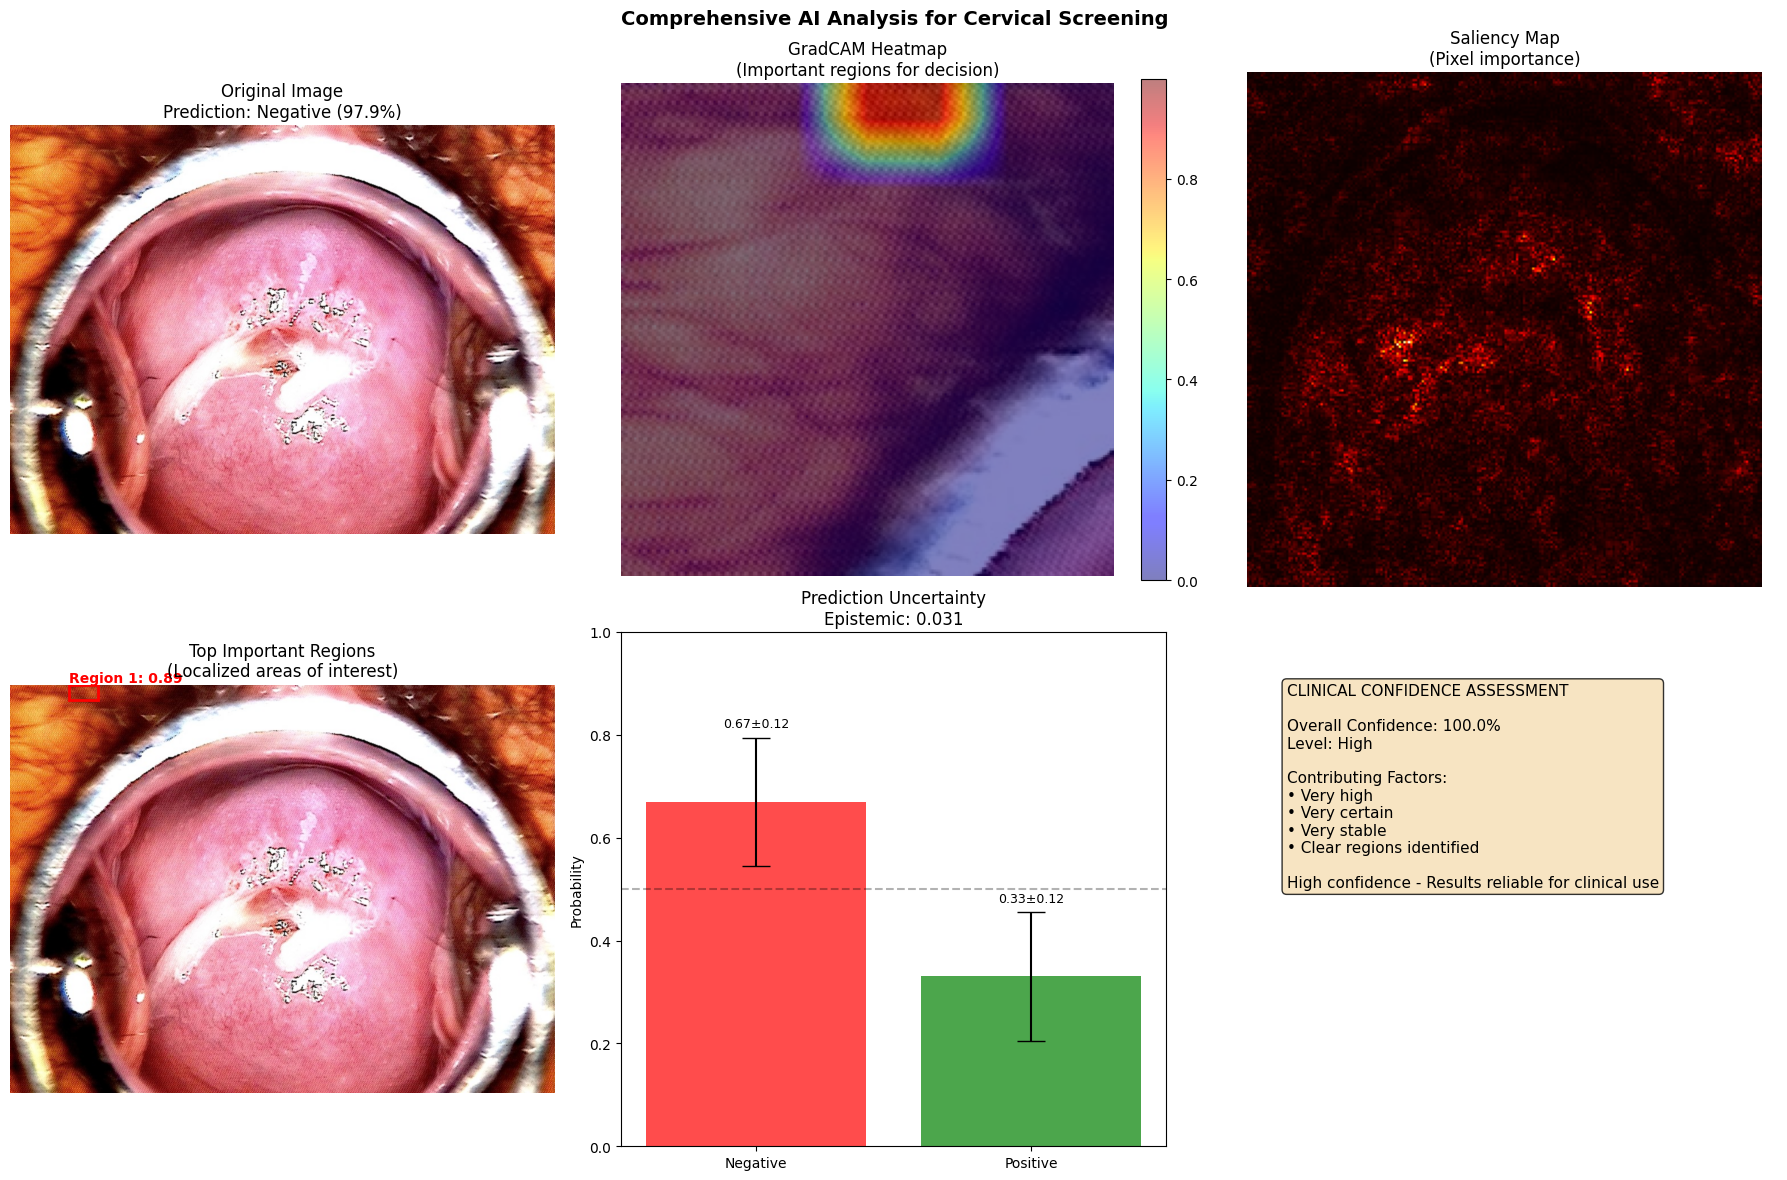


CLINICAL REPORT

╔══════════════════════════════════════════════════════════════════════╗
║               CERVICAL SCREENING AI ANALYSIS REPORT                  ║
╚══════════════════════════════════════════════════════════════════════╝

PATIENT INFORMATION
─────────────────────────────────────────────────────────────────────
Image: AAA1.jpg
Analysis Date: 2025-09-10 07:09:38
Model Version: SSL-EfficientNet-B0

PREDICTION SUMMARY
─────────────────────────────────────────────────────────────────────
Primary Classification: Negative
Confidence Score: 97.9%

Probability Distribution:
  • Negative (Normal): 97.9%
  • Positive (Abnormal): 2.1%

UNCERTAINTY ANALYSIS
─────────────────────────────────────────────────────────────────────
Model Certainty: 0.031
Feature Stability: 100.0%
Prediction Reliability: HIGH

95% Confidence Intervals:
  • Negative: [0.43, 0.91]
  • Positive: [0.09, 0.57]

VISUAL ANALYSIS
─────────────────────────────────────────────────────────────────────
Number of Signi

In [14]:
# ============================================================
# Execute Inference Demo
# ============================================================
if __name__ == "__main__":
    inference_model = main()
    
    # Additional usage examples
    print("\n" + "="*60)
    print("USAGE EXAMPLES")
    print("="*60)
    print("""
# To analyze a single image:
results = inference_model.predict_with_explanation('path/to/image.jpg')

# To generate a clinical report:
report = generate_clinical_report('path/to/image.jpg', results)

# To process multiple images:
batch_results, stats = process_batch_images(
    inference_model,
    ['image1.jpg', 'image2.jpg', 'image3.jpg']
)

# To get just predictions without explanations:
prediction = inference_model.predict('path/to/image.jpg')
""")